In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data preprocessing (same as before)
df = pd.read_csv("../treedata.csv")
df = df.drop(columns=["ObjectID", "Other.1", "Length of Failed Part", "Diameter of Failed Part"], axis=1)
df = df.fillna("None")

categorical_cols = [
    "Tree Species", "Condition", "Site Factors", "Type of Soil", "Weather factors",
    "Failed Part", "Root Failure", "Stem Failure", "Branch Failure",
    "Location and Percentage of Decay", "Decay Present"
]

from collections import defaultdict
all_unique_labels = defaultdict(set)

# extract all unique labels per column
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].apply(lambda x: [item.strip() for item in x.split(",") if item.strip() != ""])
    for items in df[col]:
        all_unique_labels[col].update(items)

for col in categorical_cols:
    for label in all_unique_labels[col]:
        df[f"{col}_{label}"] = df[col].apply(lambda x: int(label in x))

df = df.drop(columns=categorical_cols)

X = df.drop(columns=["Failed Part_BranchFailure", "Failed Part_RootFailure", "Failed Part_StemFailure"])

Using device: cpu


In [13]:
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [17]:
class TreeFailureNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64, 32], dropout_rate=0.4):
        super(TreeFailureNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class EarlyStopping:
    """Early stopping utility class"""
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        
        if mode == 'min':
            self.monitor_op = lambda current, best: current < (best - self.min_delta)
        else:
            self.monitor_op = lambda current, best: current > (best + self.min_delta)
    
    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif self.monitor_op(score, self.best_score):
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        
        return self.early_stop
    
    def save_checkpoint(self, model):
        """Save model when validation score improves"""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()

class TreeFailureTrainer:
    def __init__(self, input_size, model_name, hidden_sizes=[256, 128, 64, 32], dropout_rate=0.4, 
                 learning_rate=0.001, batch_size=32, epochs=100, early_stopping_patience=15,
                 early_stopping_min_delta=0.001, early_stopping_mode='min'):
        self.model = TreeFailureNet(input_size, hidden_sizes, dropout_rate).to(device)
        self.model_name = model_name
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=10, factor=0.5)
        self.batch_size = batch_size
        self.epochs = epochs
        self.scaler = StandardScaler()
        
        # Early stopping parameters
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=early_stopping_min_delta,
            restore_best_weights=True,
            mode=early_stopping_mode
        )
        
    def prepare_data(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_scaled).to(device),
            torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test_scaled).to(device),
            torch.FloatTensor(y_test.values).unsqueeze(1).to(device)
        )
        
        return (
            DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True),
            DataLoader(test_dataset, batch_size=self.batch_size),
            X_test_scaled, y_test
        )
    
    def train(self, X, y):
        train_loader, test_loader, X_test_scaled, y_test = self.prepare_data(X, y)
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_loss = float('inf')
        epochs_run = 0
        
        print(f"Training {self.model_name} with early stopping (patience={self.early_stopping.patience})")
        
        for epoch in range(self.epochs):
            epochs_run = epoch + 1
            
            # Training phase
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                epoch_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
            
            # Validation phase
            val_loss, val_acc = self.evaluate(test_loader)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save history
            history['train_loss'].append(epoch_loss/len(train_loader))
            history['val_loss'].append(val_loss)
            history['train_acc'].append(100*correct/total)
            history['val_acc'].append(val_acc)
            
            # Check for best model (for manual saving)
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'scaler': self.scaler,
                    'history': history,
                    'epoch': epoch,
                    'best_val_loss': best_loss
                }, f'models/{self.model_name}_best.pth')
            
            # Early stopping check
            if self.early_stopping(val_loss, self.model):
                print(f'Early stopping triggered at epoch {epoch+1}')
                print(f'Best validation loss: {self.early_stopping.best_score:.4f}')
                break
            
            # Print progress
            print(f'Epoch {epoch+1}/{self.epochs} | '
                  f'Train Loss: {history["train_loss"][-1]:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {history["train_acc"][-1]:.2f}% | '
                  f'Val Acc: {val_acc:.2f}% | '
                  f'ES Counter: {self.early_stopping.counter}/{self.early_stopping.patience}')
        
        # Save final model and results
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'scaler': self.scaler,
            'history': history,
            'X_test': X_test_scaled,
            'y_test': y_test.values,
            'epochs_trained': epochs_run,
            'early_stopped': self.early_stopping.early_stop,
            'best_val_loss': self.early_stopping.best_score
        }, f'models/{self.model_name}_final.pth')
        
        print(f"Training completed after {epochs_run} epochs")
        if self.early_stopping.early_stop:
            print("Training stopped early due to lack of improvement")
        
        return history
    
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in loader:
                outputs = self.model(batch_X)
                total_loss += self.criterion(outputs, batch_y).item()
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        return total_loss/len(loader), 100*correct/total

# Enhanced train_all_models function with early stopping parameters
def train_all_models(X, y_root, y_stem, y_branch, epochs=100, early_stopping_patience=15):
    """
    Train all tree failure models with early stopping
    
    Args:
        X: Feature matrix
        y_root, y_stem, y_branch: Target variables for each failure type
        epochs: Maximum number of epochs to train
        early_stopping_patience: Number of epochs to wait before stopping if no improvement
    """
    models = {
        'root': y_root,
        'stem': y_stem,
        'branch': y_branch
    }
    
    training_results = {}
    
    for name, y in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name} failure model...")
        print(f"{'='*50}")
        
        trainer = TreeFailureTrainer(
            input_size=X.shape[1], 
            model_name=f"tree_{name}_failure", 
            epochs=epochs,
            early_stopping_patience=early_stopping_patience,
            early_stopping_min_delta=0.001,
            early_stopping_mode='min'
        )
        
        history = trainer.train(X, y)
        training_results[name] = {
            'history': history,
            'trainer': trainer
        }
        
        print(f"Completed training for {name} failure model")
    
    return training_results

# Execute training with early stopping
training_results = train_all_models(
    X, 
    df['Failed Part_RootFailure'], 
    df['Failed Part_StemFailure'], 
    df['Failed Part_BranchFailure'],
    epochs=100,
    early_stopping_patience=15  # Stop if no improvement for 15 epochs
)
print("\n" + "="*60)
print("FINAL MODEL ACCURACIES")
print("="*60)

for model_name in ['root', 'stem', 'branch']:
    if model_name in training_results:
        history = training_results[model_name]['history']
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        best_val_acc = max(history['val_acc'])
        
        print(f"{model_name.upper()} FAILURE MODEL:")
        print(f"  Final Training Accuracy:   {final_train_acc:.2f}%")
        print(f"  Final Validation Accuracy: {final_val_acc:.2f}%")
        print(f"  Best Validation Accuracy:  {best_val_acc:.2f}%")
        print("-" * 40)

print("Training pipeline completed successfully!")
print("="*60)


Training root failure model...
Training tree_root_failure with early stopping (patience=15)
Epoch 1/100 | Train Loss: 0.7042 | Val Loss: 0.7002 | Train Acc: 52.56% | Val Acc: 35.76% | ES Counter: 0/15
Epoch 2/100 | Train Loss: 0.6525 | Val Loss: 0.6461 | Train Acc: 63.07% | Val Acc: 71.52% | ES Counter: 0/15
Epoch 3/100 | Train Loss: 0.5786 | Val Loss: 0.5656 | Train Acc: 71.31% | Val Acc: 82.78% | ES Counter: 0/15
Epoch 4/100 | Train Loss: 0.5178 | Val Loss: 0.4811 | Train Acc: 81.82% | Val Acc: 87.42% | ES Counter: 0/15
Epoch 5/100 | Train Loss: 0.4629 | Val Loss: 0.4095 | Train Acc: 82.95% | Val Acc: 87.42% | ES Counter: 0/15
Epoch 6/100 | Train Loss: 0.3992 | Val Loss: 0.3641 | Train Acc: 88.07% | Val Acc: 87.42% | ES Counter: 0/15
Epoch 7/100 | Train Loss: 0.3533 | Val Loss: 0.3453 | Train Acc: 89.77% | Val Acc: 87.42% | ES Counter: 0/15
Epoch 8/100 | Train Loss: 0.3226 | Val Loss: 0.3179 | Train Acc: 90.91% | Val Acc: 88.08% | ES Counter: 0/15
Epoch 9/100 | Train Loss: 0.2913 | 

Generating Tree Failure Model Analysis Dashboard...
1. Plotting training history...


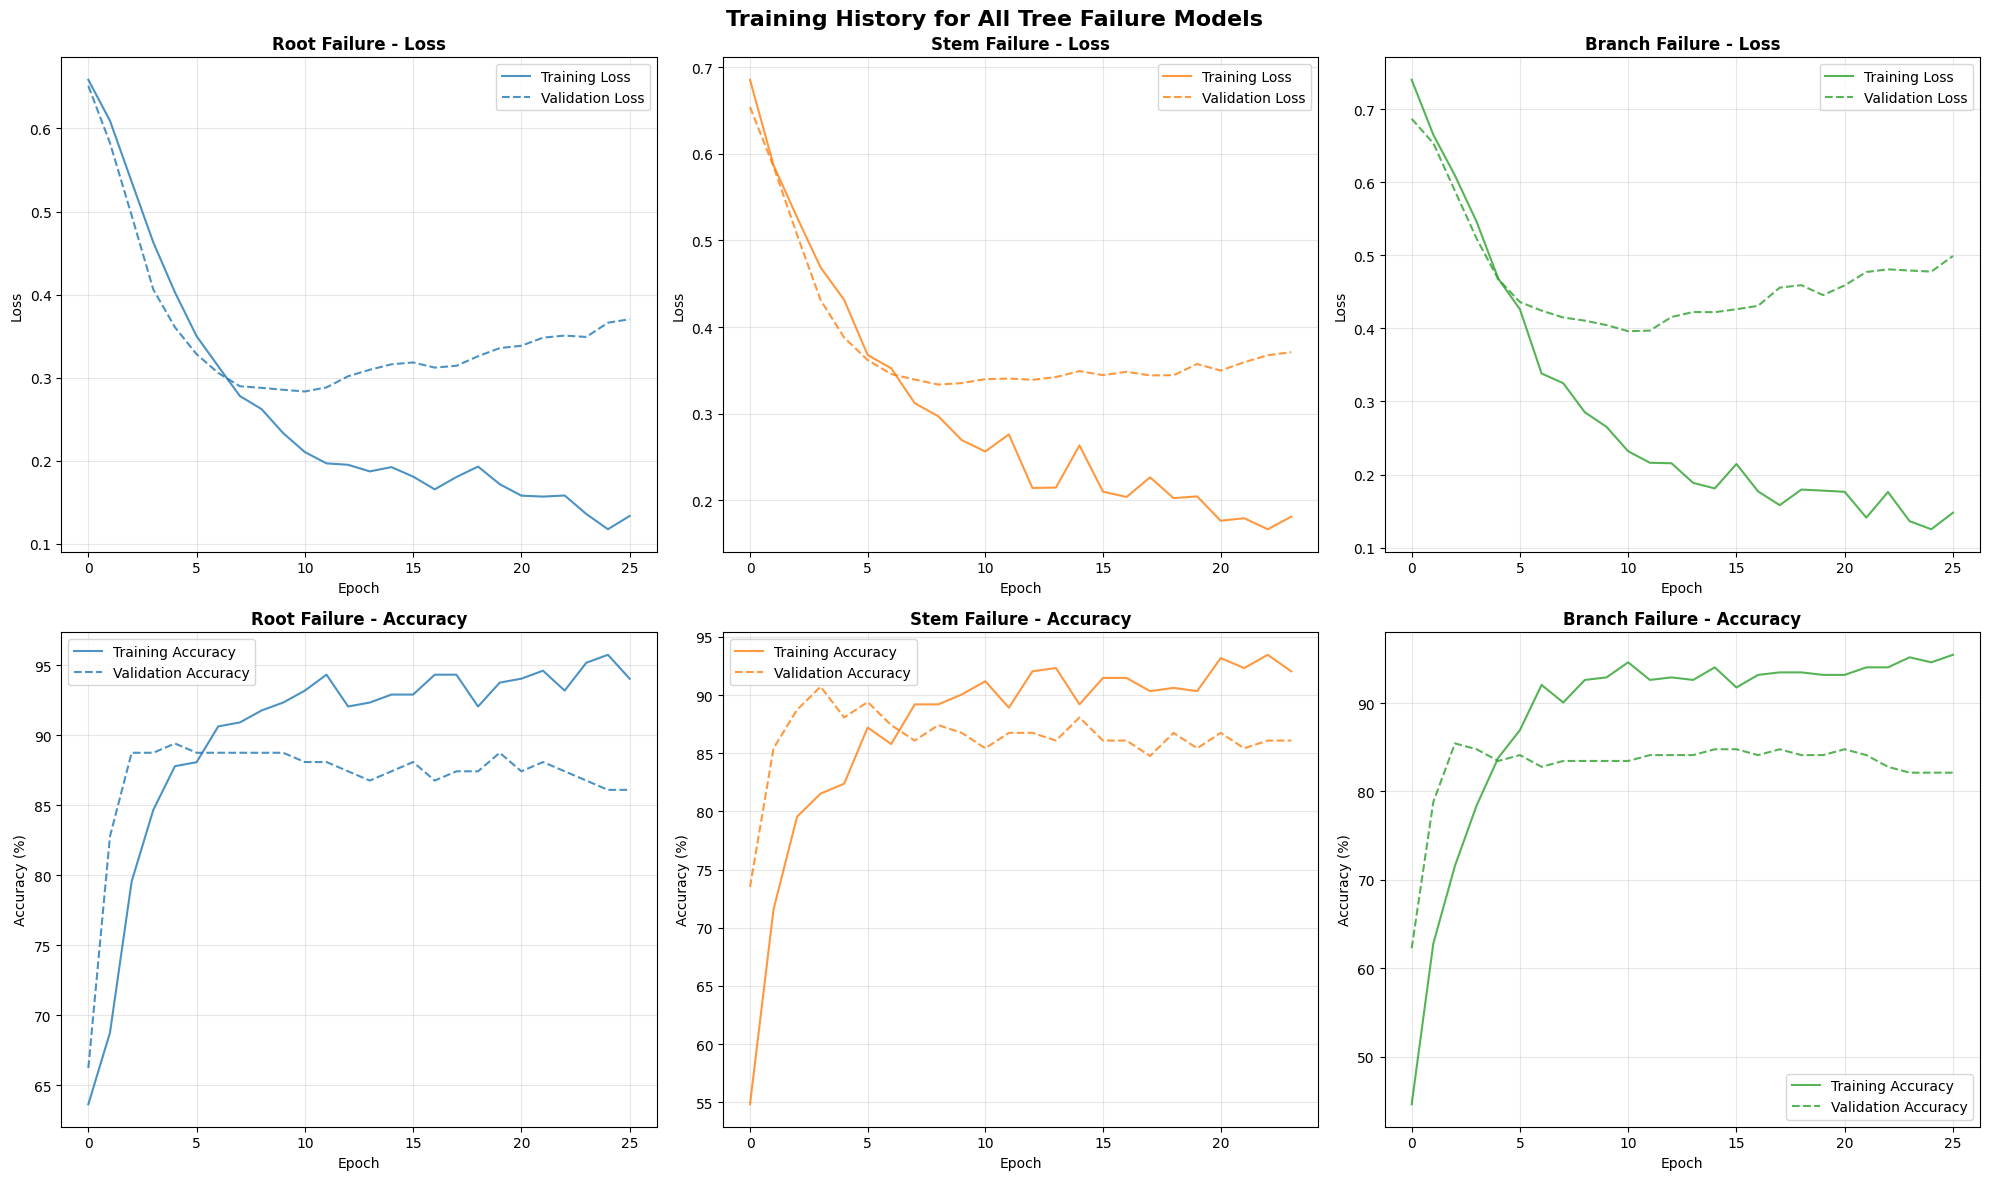

2. Plotting combined metrics...


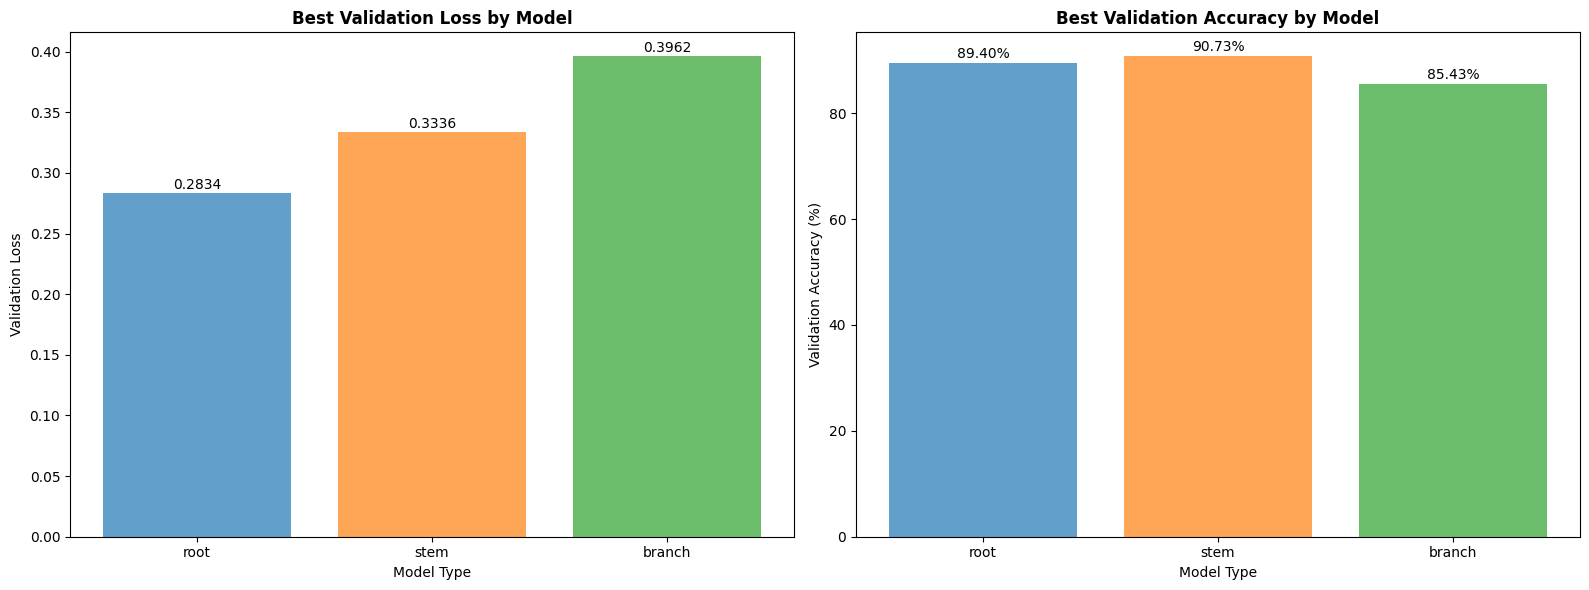

3. Generating predictions and evaluating models...
4. Plotting confusion matrices...


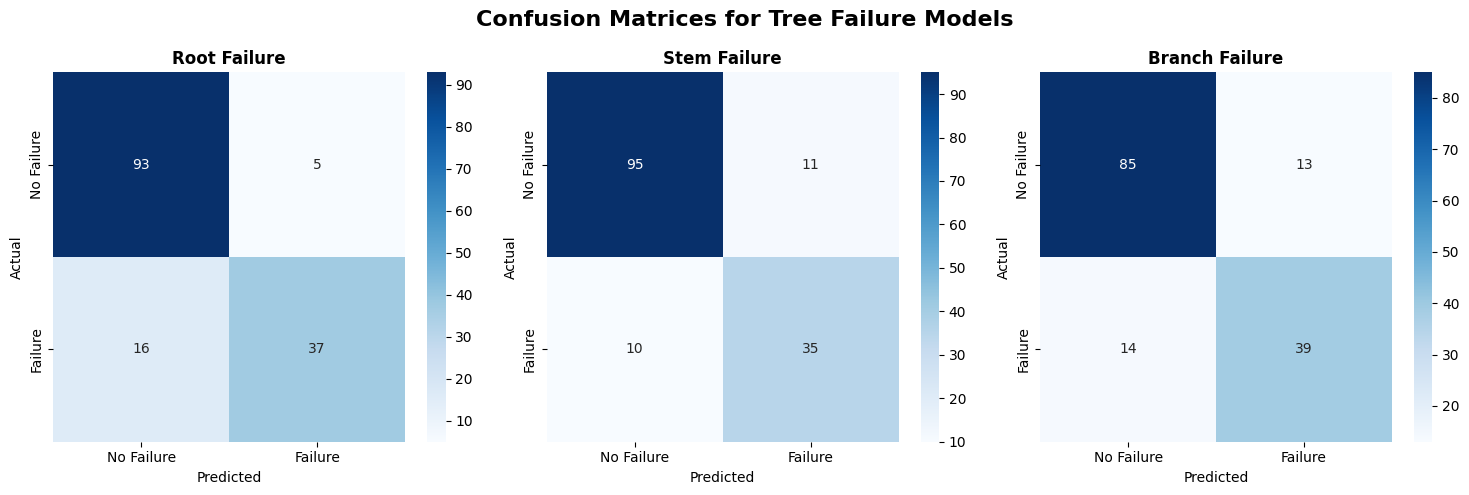

5. Plotting ROC curves...


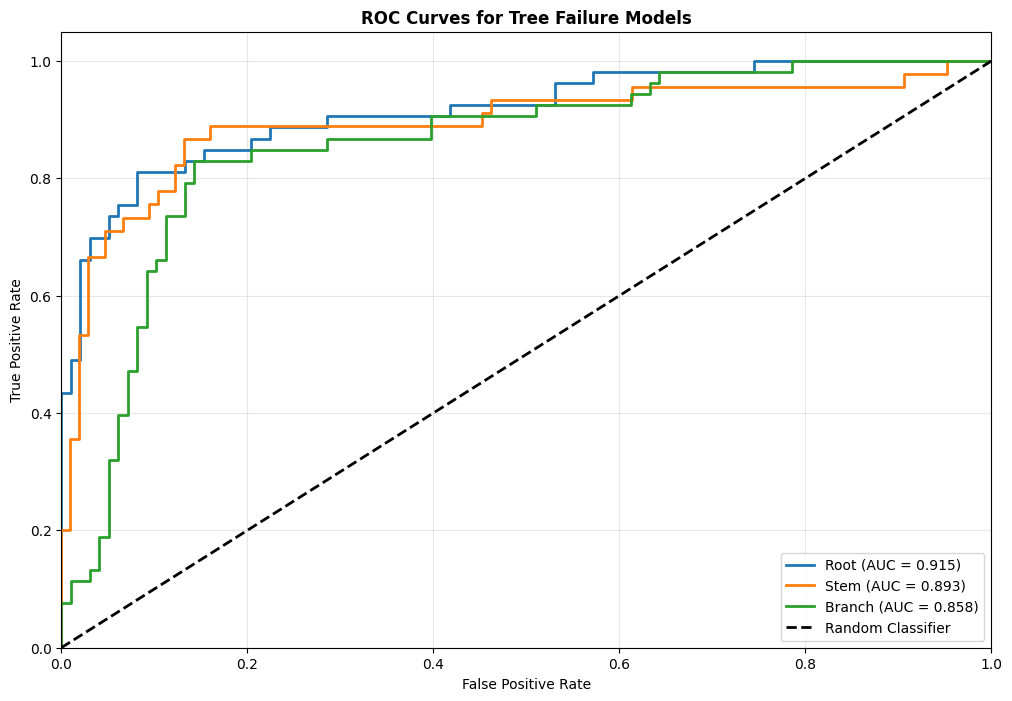

6. Plotting Precision-Recall curves...


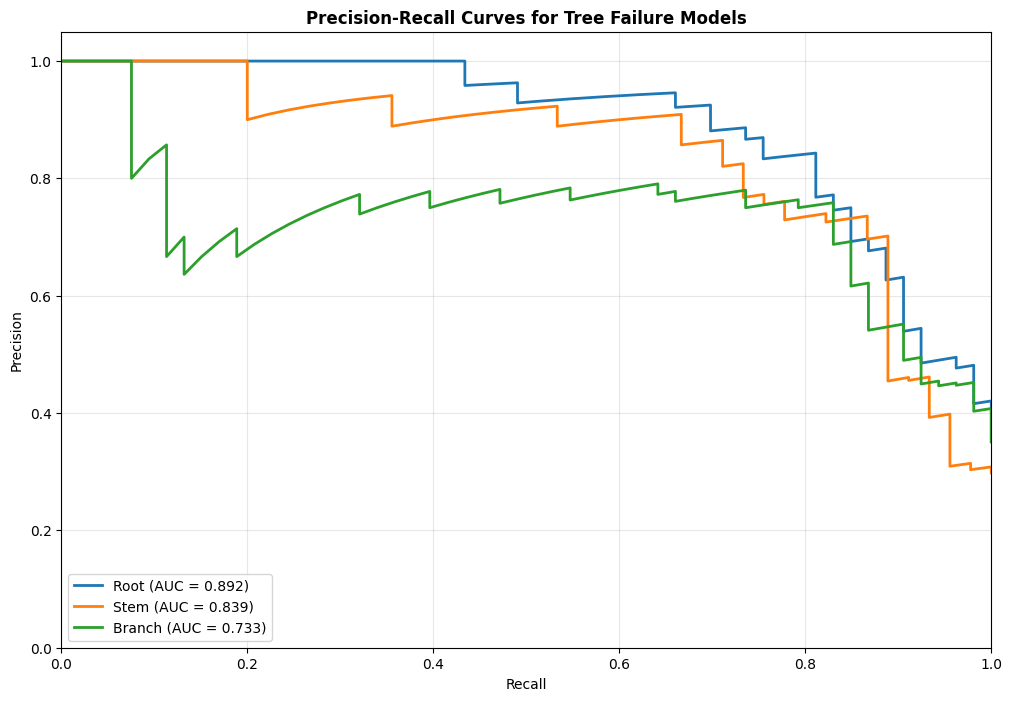

7. Plotting prediction distributions...


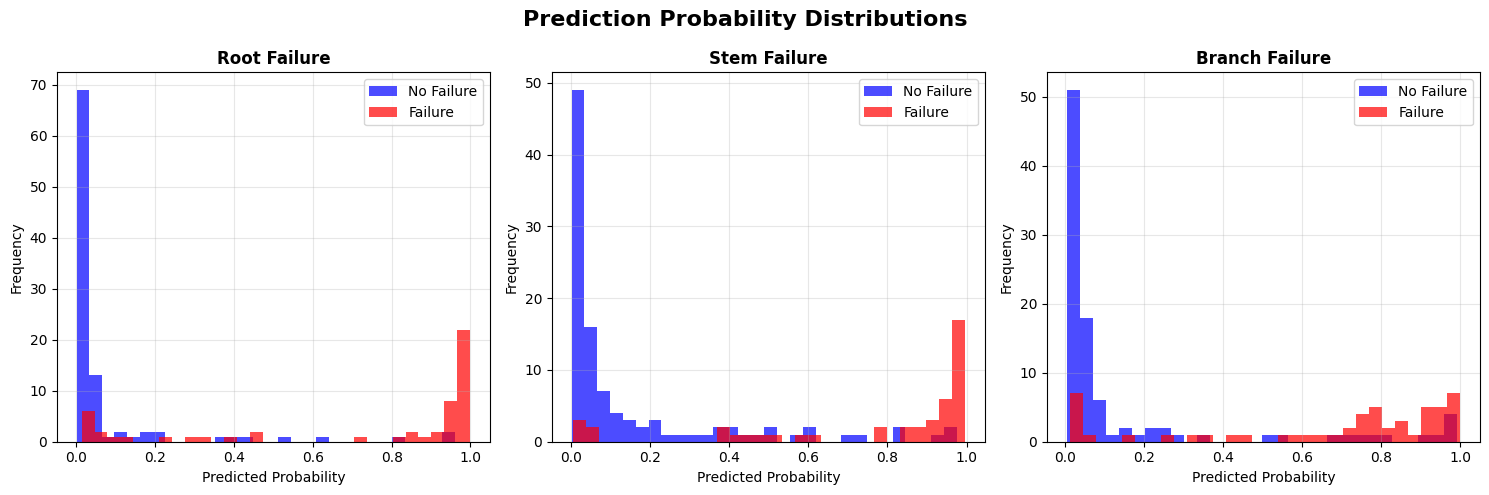

8. Generating classification reports...
CLASSIFICATION REPORTS

ROOT FAILURE MODEL:
--------------------------------------------------
              precision    recall  f1-score   support

  No Failure     0.8532    0.9490    0.8986        98
     Failure     0.8810    0.6981    0.7789        53

    accuracy                         0.8609       151
   macro avg     0.8671    0.8235    0.8387       151
weighted avg     0.8629    0.8609    0.8566       151


STEM FAILURE MODEL:
--------------------------------------------------
              precision    recall  f1-score   support

  No Failure     0.9048    0.8962    0.9005       106
     Failure     0.7609    0.7778    0.7692        45

    accuracy                         0.8609       151
   macro avg     0.8328    0.8370    0.8349       151
weighted avg     0.8619    0.8609    0.8614       151


BRANCH FAILURE MODEL:
--------------------------------------------------
              precision    recall  f1-score   support

  No Failu

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import torch
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

class TreeFailureVisualizer:
    """Comprehensive visualization class for tree failure model analysis"""
    
    def __init__(self, training_results, model_names=['root', 'stem', 'branch']):
        self.training_results = training_results
        self.model_names = model_names
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
        
    def plot_training_history(self, figsize=(20, 12)):
        """Plot training and validation loss/accuracy for all models"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Training History for All Tree Failure Models', fontsize=16, fontweight='bold')
        
        for idx, model_name in enumerate(self.model_names):
            history = self.training_results[model_name]['history']
            color = self.colors[idx]
            
            # Loss plot
            axes[0, idx].plot(history['train_loss'], label='Training Loss', color=color, alpha=0.8)
            axes[0, idx].plot(history['val_loss'], label='Validation Loss', color=color, linestyle='--', alpha=0.8)
            axes[0, idx].set_title(f'{model_name.capitalize()} Failure - Loss', fontweight='bold')
            axes[0, idx].set_xlabel('Epoch')
            axes[0, idx].set_ylabel('Loss')
            axes[0, idx].legend()
            axes[0, idx].grid(True, alpha=0.3)
            
            # Accuracy plot
            axes[1, idx].plot(history['train_acc'], label='Training Accuracy', color=color, alpha=0.8)
            axes[1, idx].plot(history['val_acc'], label='Validation Accuracy', color=color, linestyle='--', alpha=0.8)
            axes[1, idx].set_title(f'{model_name.capitalize()} Failure - Accuracy', fontweight='bold')
            axes[1, idx].set_xlabel('Epoch')
            axes[1, idx].set_ylabel('Accuracy (%)')
            axes[1, idx].legend()
            axes[1, idx].grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()
    
    def plot_combined_metrics(self, figsize=(16, 6)):
        """Plot combined loss and accuracy comparison"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Final validation loss comparison
        final_val_losses = []
        final_val_accs = []
        
        for model_name in self.model_names:
            history = self.training_results[model_name]['history']
            final_val_losses.append(min(history['val_loss']))
            final_val_accs.append(max(history['val_acc']))
        
        # Bar plot for final validation losses
        bars1 = ax1.bar(self.model_names, final_val_losses, color=self.colors, alpha=0.7)
        ax1.set_title('Best Validation Loss by Model', fontweight='bold')
        ax1.set_ylabel('Validation Loss')
        ax1.set_xlabel('Model Type')
        
        # Add value labels on bars
        for bar, val in zip(bars1, final_val_losses):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{val:.4f}', ha='center', va='bottom')
        
        # Bar plot for final validation accuracies
        bars2 = ax2.bar(self.model_names, final_val_accs, color=self.colors, alpha=0.7)
        ax2.set_title('Best Validation Accuracy by Model', fontweight='bold')
        ax2.set_ylabel('Validation Accuracy (%)')
        ax2.set_xlabel('Model Type')
        
        # Add value labels on bars
        for bar, val in zip(bars2, final_val_accs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.2f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def generate_predictions_and_evaluate(self):
        """Generate predictions for all models and return evaluation metrics"""
        evaluation_results = {}
        
        for model_name in self.model_names:
            # Load the saved model
            model_path = f'models/tree_{model_name}_failure_final.pth'
            try:
                checkpoint = torch.load(model_path, map_location=device)
                
                # Get test data
                X_test = checkpoint['X_test']
                y_test = checkpoint['y_test']
                
                # Load model
                trainer = self.training_results[model_name]['trainer']
                trainer.model.load_state_dict(checkpoint['model_state_dict'])
                trainer.model.eval()
                
                # Generate predictions
                with torch.no_grad():
                    X_test_tensor = torch.FloatTensor(X_test).to(device)
                    y_prob = trainer.model(X_test_tensor).cpu().numpy().flatten()
                    y_pred = (y_prob > 0.5).astype(int)
                
                evaluation_results[model_name] = {
                    'y_true': y_test,
                    'y_pred': y_pred,
                    'y_prob': y_prob
                }
                
            except FileNotFoundError:
                print(f"Model file not found for {model_name}. Skipping evaluation.")
                continue
                
        return evaluation_results
    
    def plot_confusion_matrices(self, evaluation_results, figsize=(15, 5)):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle('Confusion Matrices for Tree Failure Models', fontsize=16, fontweight='bold')
        
        for idx, model_name in enumerate(self.model_names):
            if model_name not in evaluation_results:
                continue
                
            y_true = evaluation_results[model_name]['y_true']
            y_pred = evaluation_results[model_name]['y_pred']
            
            cm = confusion_matrix(y_true, y_pred)
            
            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['No Failure', 'Failure'],
                       yticklabels=['No Failure', 'Failure'],
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name.capitalize()} Failure', fontweight='bold')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
            
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self, evaluation_results, figsize=(12, 8)):
        """Plot ROC curves for all models"""
        plt.figure(figsize=figsize)
        
        for idx, model_name in enumerate(self.model_names):
            if model_name not in evaluation_results:
                continue
                
            y_true = evaluation_results[model_name]['y_true']
            y_prob = evaluation_results[model_name]['y_prob']
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, color=self.colors[idx], lw=2, 
                    label=f'{model_name.capitalize()} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Tree Failure Models', fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_precision_recall_curves(self, evaluation_results, figsize=(12, 8)):
        """Plot Precision-Recall curves for all models"""
        plt.figure(figsize=figsize)
        
        for idx, model_name in enumerate(self.model_names):
            if model_name not in evaluation_results:
                continue
                
            y_true = evaluation_results[model_name]['y_true']
            y_prob = evaluation_results[model_name]['y_prob']
            
            precision, recall, _ = precision_recall_curve(y_true, y_prob)
            pr_auc = auc(recall, precision)
            
            plt.plot(recall, precision, color=self.colors[idx], lw=2,
                    label=f'{model_name.capitalize()} (AUC = {pr_auc:.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves for Tree Failure Models', fontweight='bold')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_prediction_distributions(self, evaluation_results, figsize=(15, 5)):
        """Plot prediction probability distributions"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle('Prediction Probability Distributions', fontsize=16, fontweight='bold')
        
        for idx, model_name in enumerate(self.model_names):
            if model_name not in evaluation_results:
                continue
                
            y_true = evaluation_results[model_name]['y_true']
            y_prob = evaluation_results[model_name]['y_prob']
            
            # Separate probabilities by true class
            prob_no_failure = y_prob[y_true == 0]
            prob_failure = y_prob[y_true == 1]
            
            axes[idx].hist(prob_no_failure, bins=30, alpha=0.7, label='No Failure', color='blue')
            axes[idx].hist(prob_failure, bins=30, alpha=0.7, label='Failure', color='red')
            axes[idx].set_title(f'{model_name.capitalize()} Failure', fontweight='bold')
            axes[idx].set_xlabel('Predicted Probability')
            axes[idx].set_ylabel('Frequency')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()
    
    def print_classification_reports(self, evaluation_results):
        """Print detailed classification reports for all models"""
        print("="*80)
        print("CLASSIFICATION REPORTS")
        print("="*80)
        
        for model_name in self.model_names:
            if model_name not in evaluation_results:
                continue
                
            print(f"\n{model_name.upper()} FAILURE MODEL:")
            print("-" * 50)
            
            y_true = evaluation_results[model_name]['y_true']
            y_pred = evaluation_results[model_name]['y_pred']
            
            report = classification_report(y_true, y_pred, 
                                         target_names=['No Failure', 'Failure'],
                                         digits=4)
            print(report)
    
    def create_comprehensive_dashboard(self):
        """Create a comprehensive visualization dashboard"""
        print("Generating Tree Failure Model Analysis Dashboard...")
        print("="*60)
        
        # 1. Training history plots
        print("1. Plotting training history...")
        self.plot_training_history()
        
        # 2. Combined metrics comparison
        print("2. Plotting combined metrics...")
        self.plot_combined_metrics()
        
        # 3. Generate predictions and evaluate
        print("3. Generating predictions and evaluating models...")
        evaluation_results = self.generate_predictions_and_evaluate()
        
        if evaluation_results:
            # 4. Confusion matrices
            print("4. Plotting confusion matrices...")
            self.plot_confusion_matrices(evaluation_results)
            
            # 5. ROC curves
            print("5. Plotting ROC curves...")
            self.plot_roc_curves(evaluation_results)
            
            # 6. Precision-Recall curves
            print("6. Plotting Precision-Recall curves...")
            self.plot_precision_recall_curves(evaluation_results)
            
            # 7. Prediction distributions
            print("7. Plotting prediction distributions...")
            self.plot_prediction_distributions(evaluation_results)
            
            # 8. Classification reports
            print("8. Generating classification reports...")
            self.print_classification_reports(evaluation_results)
        
        print("\nDashboard generation completed!")

# Usage example:
# Assuming you have your training_results from the previous training
"""
# Initialize the visualizer
visualizer = TreeFailureVisualizer(training_results)

# Create the comprehensive dashboard
visualizer.create_comprehensive_dashboard()

# Or use individual visualization methods:
# visualizer.plot_training_history()
# evaluation_results = visualizer.generate_predictions_and_evaluate()
# visualizer.plot_confusion_matrices(evaluation_results)
# visualizer.plot_roc_curves(evaluation_results)
"""

visualizer = TreeFailureVisualizer(training_results)
visualizer.create_comprehensive_dashboard()
